<a href="https://colab.research.google.com/github/gyozo-terplan/medicine_consumption/blob/main/medicine_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
patients = pd.read_parquet('/content/drive/MyDrive/medcine/patients.parquet')

In [6]:
def create_categories(df):

  """
    Create categories based on ATC code
    Arguments:
        df: input df
    Returns:
        Modified df which includes drug type column 
  """

  df = df.copy(deep=True)
  df['drug_type'] = 'Other'
  df.loc[df.ATC.str.contains('^N01'),'drug_type'] = 'Anesthetics'
  df.loc[df.ATC.str.contains('^N02A'), 'drug_type'] = 'Opioids'
  df.loc[df.ATC.str.contains('^N02B'), 'drug_type'] = 'Other analgesics and antipyretics'
  df.loc[df.ATC.str.contains('^N02C'), 'drug_type'] = 'Antimigraine preparations'
  df.loc[df.ATC.str.contains('^N03'), 'drug_type'] = 'Antiepileptics'
  df.loc[df.ATC.str.contains('^N04'), 'drug_type'] = 'Anti-parkinson drugs'
  df.loc[df.ATC.str.contains('^N05A'), 'drug_type'] = 'Antipsychotics'
  df.loc[df.ATC.str.contains('^N05B'), 'drug_type'] = 'Anxiolytics'
  df.loc[df.ATC.str.contains('^N05C'), 'drug_type'] = 'Hypnotics and sedatives'
  df.loc[df.ATC.str.contains('^N06A'), 'drug_type'] = 'Antidepressants'
  df.loc[df.ATC.str.contains('^N06B'),'drug_type'] = 'Psychostimulants'
  df.loc[df.ATC.str.contains('^N06D'), 'drug_type'] = 'Anti-dementia drugs'
  df.loc[df.ATC.str.contains('^N07B'),'drug_type'] = 'Drugs used in addictive disorders'
  df.loc[df.ATC.str.contains('^N07C'), 'drug_type'] = 'Antivertigo preparations'
  df.loc[df.ATC.str.contains('^N07X'), 'drug_type'] = 'Other nervous system drugs'
  df.loc[df.ATC.str.contains('^L'), 'drug_type'] = 'Antineoplastic and immunomodulating agents'

  return df



In [8]:
def col_parsing(df):

  """
    Parsing columns of the dataframe
    Arguments:
        df: input dataframe
    Returns:
        Modified dataframe with parsed columns
  """

  df = df.copy(deep=True)
  df['drug_type'] = df.drug_type.astype('category')
  df['date'] = pd.to_datetime(pd.concat([df.month.str[0:4].rename('year'),df.month.str[4:].rename('month')], axis=1).assign(day=1))
  df['month'] = df['date'].dt.month

  return df

In [9]:
def grouping_by_drug(df):
  
  """
    Parsing columns of the dataframe
    Arguments:
        df: input dataframe
    Returns:
        Modified dataframe with parsed columns
  """

  df = df.copy(deep=True)
  df = df.groupby(['drug_type','date','month']).agg(patient_count = ('patient_count', sum)).reset_index()

  return df

In [11]:
def rm_zero_patients(df):

  """
    Deleting records where is 0 patients
    Arguments:
        df: input dataframe
    Returns:
        Modified dataframe without 0 patient rows
  """

  df = df.copy(deep=True)
  df = df[df['patient_count']!= 0] 
  df.drug_type = df.drug_type.cat.remove_unused_categories()
   
  return df

In [12]:
patients_cleaned = (patients
                    .pipe(create_categories)
                    .pipe(col_parsing)
                    .pipe(grouping_by_drug)
                    .pipe(rm_zero_patients)
                    )


In [50]:
def mean_prev_years(df):

  """
  Calculating the mean number of patients in 4 years before covid and the number of patients in 2019
  Arguments:
        df: input dataframe
  Returns:
        Modified dataframe with previous 4 year average and 2019 patient numbers
  """

  df = df.copy(deep=True)
  prev_years = df.loc[df['date'].between('2015-01-01', '2019-12-01')] \
                 .groupby(['drug_type','month']) \
                 .agg(avg_patients_15_19 = ('patient_count','mean')) \
                 .reset_index()
  
  
  year_2019 = patients_cleaned.loc[patients_cleaned['date'].between('2019-01-01', '2019-12-01')] \
                              .rename(columns={'patient_count': 'patient_count_2019'}) \
                              .drop(['date'], axis=1)

  df = df.loc[df['date']>='2020-01-01'].merge(prev_years, on=['drug_type','month']) \
                                       .merge(year_2019, on=['drug_type','month'])


  df = pd.melt(df, id_vars=['date','drug_type'], 
               value_vars=['patient_count','patient_count_2019','avg_patients_15_19'])

  df.variable = pd.Categorical(df.variable).rename_categories(
                        {'avg_patients_15_19': 'Average number of patients between 2015-2019 same month'
                        ,'patient_count': 'Number of patients'
                        ,'patient_count_2019': 'Number of patients in 2019 same month'})

  return df

In [51]:
multiyear_comp = mean_prev_years(patients_cleaned)

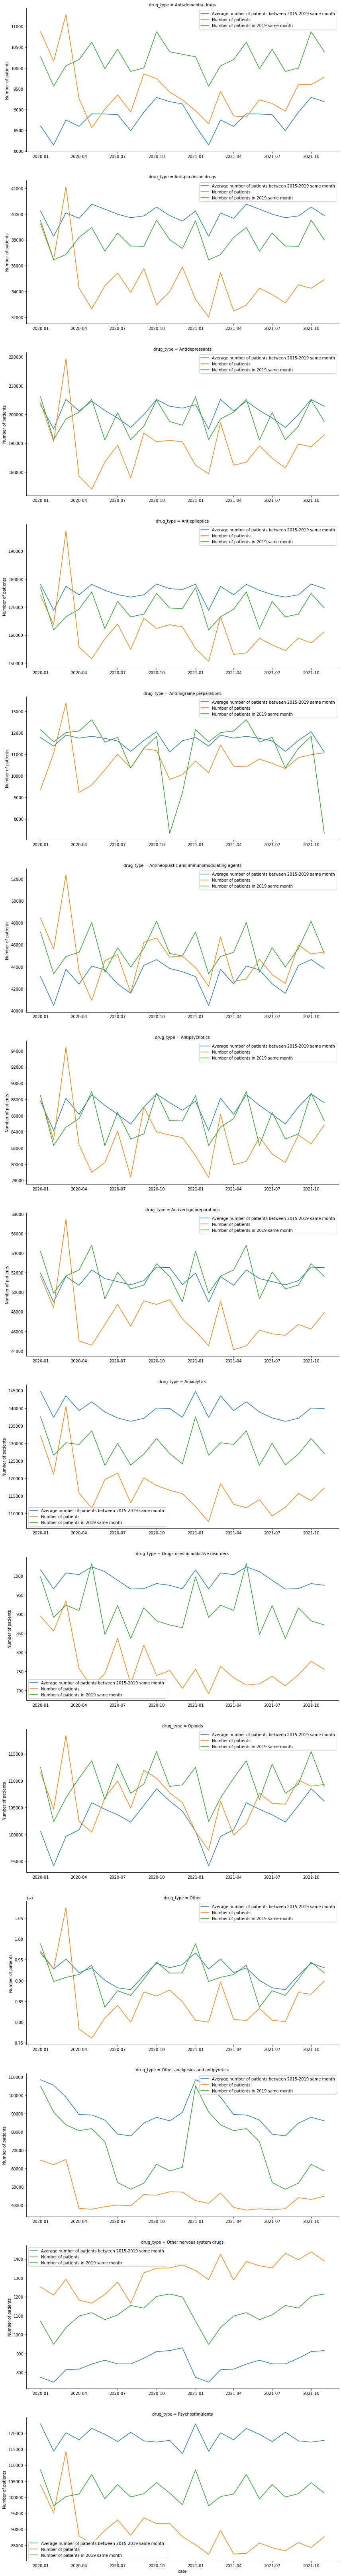

In [53]:
g = sns.FacetGrid(multiyear_comp
                  ,row="drug_type"
                  ,hue="variable"
                  ,height=6
                  ,aspect=2
                  ,sharey=False)

g.map(sns.lineplot, 'date', 'value')
g.figure.subplots_adjust()

plt.subplots_adjust(hspace=0.2)

for ax in g.axes.ravel():
    ax.legend()
    ax.set_ylabel('Number of patients')
    ax.tick_params(labelbottom=True)

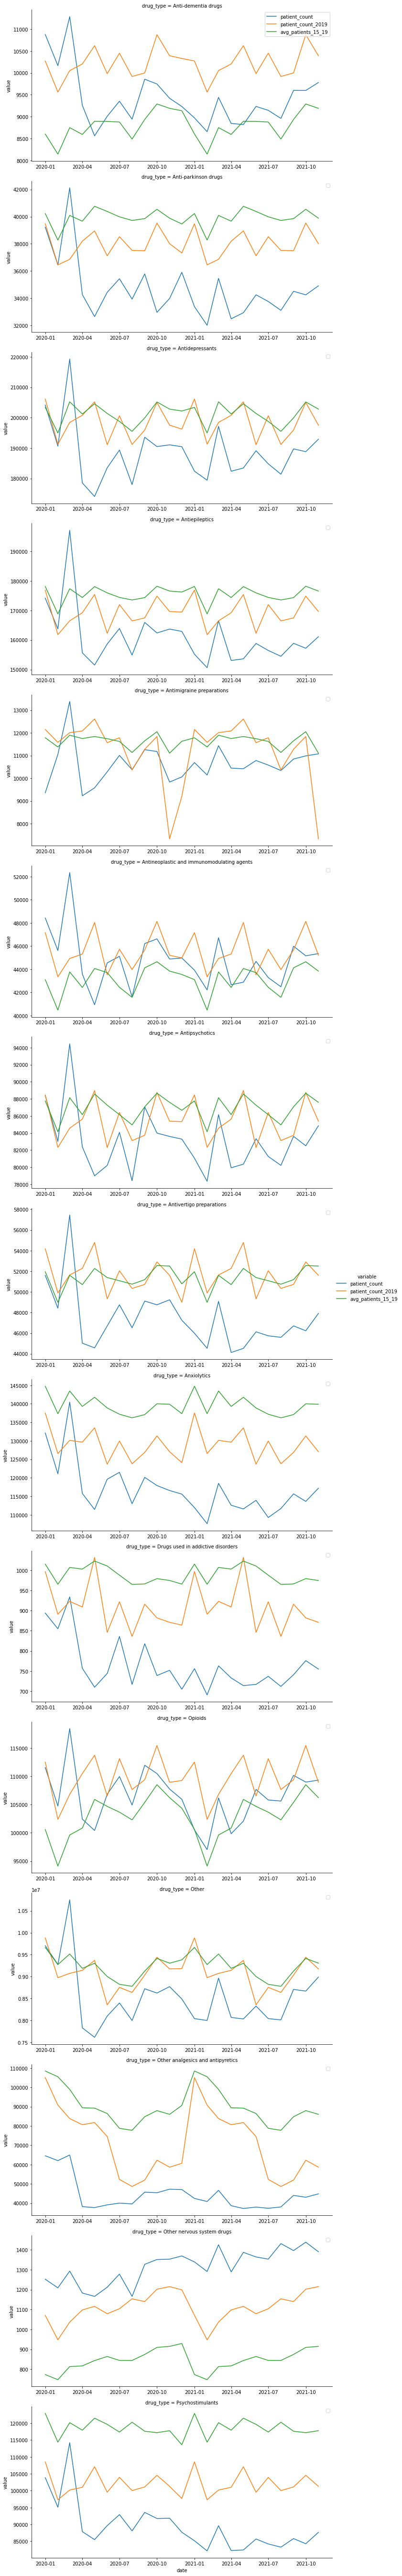

In [18]:
g = sns.relplot(
    data=multiyear_comp,
    x="date", y="value",
    hue="variable",  row="drug_type",
    kind="line", size_order=["T1", "T2"], 
    height=5, aspect=2, facet_kws=dict(sharex=False,sharey=False),
)

for ax in g.axes.ravel():
    ax.legend()
